# LSTM second attempt


In [160]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [161]:
def select_device():
    # Check for CUDA GPU availability (typically NVIDIA GPUs)
    if torch.cuda.is_available():
        return torch.device("cuda"), "NVIDIA GPU"
    
    # Check for MPS availability (for Apple Silicon GPUs)
    elif torch.backends.mps.is_available():
        return torch.device("mps"), "Apple Silicon GPU"
    
    # Fallback to CPU
    else:
        return torch.device("cpu"), "CPU"

# Select the best available device
device, device_name = select_device()
print(f"Using {device_name} for computation.")

Using Apple Silicon GPU for computation.


In [162]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path, parse_dates=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
    df = pd.DataFrame(df)
    return df

os.getcwd()
df = load_and_prepare_data('../../data/Final_data/final_data.csv')

In [163]:
# Normalize the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Function to create sequences for LSTM
def create_sequences(input_data, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)
    for i in range(data_size - sequence_length):
        sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence, label))
    return sequences

# Create sequences
sequence_length = 14 
target_column = 'Day_ahead_price'  # Target column for prediction
data_sequences = create_sequences(df_scaled, target_column, sequence_length)

# Split data into training and test sets
train_sequences, test_sequences = train_test_split(data_sequences, test_size=0.2, random_state=42)


In [164]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.device = device
        self.to(device)

    def forward(self, x):
        # Initialize hidden and cell states within the forward method, ensuring they are on the correct device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=self.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Only use the output of the last time step
        return out


# Define model parameters
input_dim = len(df.columns)  # Number of features
hidden_dim = 200
num_layers = 2
output_dim = 1


# Model instantiation and ensuring it is on the correct device
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)

In [165]:
# Data preparation
def sequences_to_tensor(sequences, device):
    X, y = [], []
    for sequence, label in sequences:
        X.append(sequence.values)
        y.append(label)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32).reshape(-1, 1)  # Ensure proper shaping
    return torch.tensor(X).to(device), torch.tensor(y).to(device)  # Move tensors to device

# Convert training and testing data to tensors
X_train, y_train = sequences_to_tensor(train_sequences, device)
X_test, y_test = sequences_to_tensor(test_sequences, device)

# Create data loaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 64  # You can adjust this depending on your GPU capacity
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


In [166]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)  # Learning rate

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure data is on the correct device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')



# Start training
num_epochs = 50
train_model(model, train_loader, criterion, optimizer, num_epochs)


Epoch 1/50, Loss: 0.005889229698888292
Epoch 2/50, Loss: 0.0026491266450778183
Epoch 3/50, Loss: 0.0016221503995309053
Epoch 4/50, Loss: 0.0016376611843692704
Epoch 5/50, Loss: 0.0015013292369466008
Epoch 6/50, Loss: 0.0019656034304976595
Epoch 7/50, Loss: 0.0016034670625231229
Epoch 8/50, Loss: 0.0016613366951787611


In [ ]:
# Assuming df is your original dataframe
price_scaler = MinMaxScaler()
prices_scaled = price_scaler.fit_transform(df[['Day_ahead_price']])  # Scale only the target column
df['Day_ahead_price_scaled'] = prices_scaled  # Store scaled prices back in DataFrame


In [ ]:
def evaluate_model(model, test_loader, scaler):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            output = model(inputs)
            predictions.extend(output.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Inverse transform to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
    
    return predictions.flatten(), actuals.flatten()

predictions, actuals = evaluate_model(model, test_loader, price_scaler)


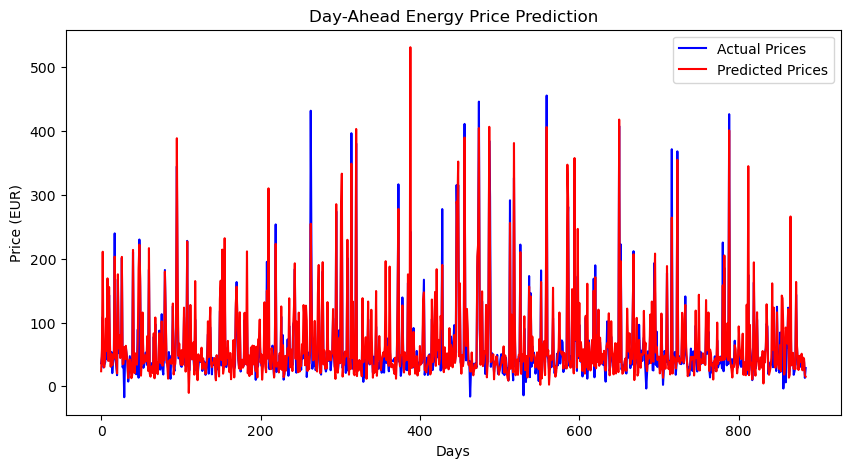

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(actuals, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.title('Day-Ahead Energy Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (EUR)')
plt.legend()
plt.show()

In [ ]:
def compute_metrics(predictions, actuals):
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)  # RMSE is just the square root of MSE

    return mse, mae, rmse

# Assume 'predictions' and 'actuals' are numpy arrays obtained from the evaluate_model function
mse, mae, rmse = compute_metrics(predictions, actuals)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 845.1579
Mean Absolute Error (MAE): 16.616322
Root Mean Squared Error (RMSE): 29.0716
